Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:56:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Ensemble Model Accuracy: 0.8047937312744872

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      4775
           1       0.80      0.75      0.78      3903

    accuracy                           0.80      8678
   macro avg       0.80      0.80      0.80      8678
weighted avg       0.80      0.80      0.80      8678



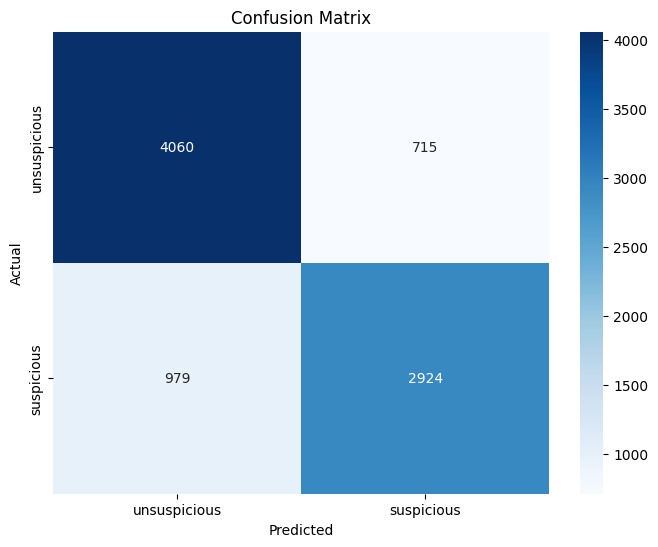


Models saved successfully in Drive.

Example Prediction: suspicious


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Install necessary libraries
!pip install gensim xgboost pandas openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from gensim.models import Word2Vec
import xgboost as xgb

# Load dataset from Google Drive
dataset_path = "/content/drive/MyDrive/suspicious Bangla text.xlsx"
df = pd.read_excel(dataset_path)

# Preprocess Text
def preprocess_text(text):
    if isinstance(text, str):
        text = text.strip()
        text = text.replace("।", "")  # Remove Bengali full stop
    else:
        text = ""
    return text

df['Text'] = df['Text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['binary_label'], test_size=0.2, random_state=42, stratify=df['binary_label'])

### 🔹 Model 1: TF-IDF + Naïve Bayes ###
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict_proba(X_test_tfidf)[:, 1]  # Get probabilities

### 🔹 Model 2: Word2Vec + XGBoost ###
# Tokenize text for Word2Vec
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = word2vec_model.wv

# Convert sentences into averaged Word2Vec vectors
def get_word2vec_features(tokens, word_vectors, vector_size=100):
    features = np.zeros((len(tokens), vector_size))
    for i, words in enumerate(tokens):
        valid_words = [word_vectors[word] for word in words if word in word_vectors]
        if valid_words:
            features[i] = np.mean(valid_words, axis=0)
    return features

X_train_w2v = get_word2vec_features(X_train_tokens, word_vectors)
X_test_w2v = get_word2vec_features(X_test_tokens, word_vectors)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_w2v, y_train)

y_pred_xgb = xgb_model.predict_proba(X_test_w2v)[:, 1]  # Get probabilities

### 🔹 Ensemble: Soft Voting ###
y_pred_ensemble = (y_pred_nb + y_pred_xgb) / 2  # Average probabilities

# Convert probabilities to final predictions
y_pred_final = (y_pred_ensemble > 0.5).astype(int)

# Evaluate Performance
accuracy = accuracy_score(y_test, y_pred_final)
print("\nEnsemble Model Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['unsuspicious', 'suspicious'], yticklabels=['unsuspicious', 'suspicious'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save models
joblib.dump(nb_model, "/content/drive/MyDrive/naive_bayes_model.pkl")
joblib.dump(vectorizer, "/content/drive/MyDrive/tfidf_vectorizer.pkl")
joblib.dump(xgb_model, "/content/drive/MyDrive/xgboost_model.pkl")
joblib.dump(word2vec_model, "/content/drive/MyDrive/word2vec_model.pkl")

print("\nModels saved successfully in Drive.")

# Prediction Function
def predict_text(new_text):
    new_text = preprocess_text(new_text)

    # TF-IDF + Naïve Bayes Prediction
    new_tfidf_vector = vectorizer.transform([new_text])
    prob_nb = nb_model.predict_proba(new_tfidf_vector)[:, 1]

    # Word2Vec + XGBoost Prediction
    new_tokens = new_text.split()
    new_w2v_vector = np.mean([word_vectors[word] for word in new_tokens if word in word_vectors], axis=0)
    new_w2v_vector = new_w2v_vector.reshape(1, -1)
    prob_xgb = xgb_model.predict_proba(new_w2v_vector)[:, 1]

    # Ensemble Soft Voting
    final_prob = (prob_nb + prob_xgb) / 2
    return "suspicious" if final_prob > 0.5 else "unsuspicious"

print("\nExample Prediction:", predict_text("এই বাক্য সন্দেহজনক"))
